# Drug Discovery for Dengue Virus NS-3 Helicase

## Primary Authors:
- Clarissa Harmoko
- Kai Ze Tam
- Kyle Carlo Lasala
- Muhammad Abdul Aziz Ghazali

## Prepare Libraries

In [1]:
!pip install biopython
!pip install nglview==3.0.8
!pip install "ipywidgets>=7,<8"
!pip install rdkit

!pip install qiskit-nature

  Using cached biopython-1.85-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 24.4 MB/s eta 0:00:0000:0100:01
  Using cached nglview-3.0.8-py3-none-any.whl
  Using cached ipywidgets-7.8.5-py2.py3-none-any.whl (124 kB)
  Using cached jupyterlab_widgets-1.1.11-py3-none-any.whl (246 kB)
  Using cached widgetsnbextension-3.6.10-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.15
    Uninstalling jupyterlab_widgets-3.0.15:
      Successfully uninstalled jupyterlab_widgets-3.0.15
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 4.0.14
    Uninstalling widgetsnbextension-4.0.14:
      Successfully uninstalled widgetsnbextension-4.0.14
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 8.1.7
    Uninstalling ipywidgets-8.1.7:
      Successfully uninstalled ipywidge

In [7]:
!pip install qiskit==1.4.3

  Using cached qiskit-1.4.3-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.8 MB)
  Using cached symengine-0.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.7 MB)
  Attempting uninstall: qiskit
    Found existing installation: qiskit 2.1.1
    Uninstalling qiskit-2.1.1:
      Successfully uninstalled qiskit-2.1.1


In [7]:
# node needed! 
# installs the js packages for nglview
!npm i


up to date, audited 548 packages in 5s

168 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities


In [2]:
# will only run in linux
!pip install --prefer-binary pyscf

  Using cached pyscf-2.10.0-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (51.2 MB)


In [1]:
import os
import ipywidgets as widgets 
from Bio.PDB import PDBList, PDBParser
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import nglview as nv
import numpy as np

In [3]:
import numpy as np
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.problems import ElectronicBasis
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.settings import settings

## Prepare Dataset

### Download the target protein
- The target is the NS3 RNA helicase (a viral protein/enzyme) of Dengue virus serotype 2 (DENV2). This helicase unwinds double-stranded RNA (dsRNA) intermediates into single-stranded RNA (ssRNA), a critical step in the replication of the viral genome.

In [4]:
pdb_id = "2BMF"
pdbl = PDBList()

In [5]:
file_path = pdbl.retrieve_pdb_file(pdb_id, file_format="pdb", pdir="./")
file_name = "DENV2_RNA_Helicase_2_4A.pdb"
if os.path.exists(file_name):
    os.remove(file_name)
os.rename(file_path, file_name)

In [6]:
parser = PDBParser(QUIET=True)
structure = parser.get_structure(pdb_id, file_name)
view = nv.show_biopython(structure)
view

NGLWidget()

### Select a particular ligand
- The ligand selected is based on the study of Halim et al. [1]. The ligand with the highest Chemgauss2 (CG2) score is selected. The Simplified Molecular Input Line Entry System (SMILES) format of the selected ligand is `CCOc1ccc2c(c1)sc(n2)NC(=O)c3c(cnc(n3)SC)Br`. This will be used to benchmark the tools.

[1] S. A. Halim, S. Khan, A. Khan, A. Wadood, F. Mabood, J. Hussain, and A. Al-Harrasi, “Targeting Dengue Virus NS-3 Helicase by Ligand based Pharmacophore Modeling and Structure based Virtual Screening,” Frontiers in Chemistry, vol. 5, p. 88, 2017. [Online]. Available: https://doi.org/10.3389/fchem.2017.00088

In [7]:
ligand = "CCOc1ccc2c(c1)sc(n2)NC(=O)c3c(cnc(n3)SC)Br"

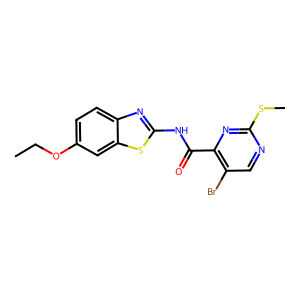

In [8]:
mol = Chem.MolFromSmiles(ligand)
Draw.MolToImage(mol)

Save this into pdb format

In [9]:
mol_wHs = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol_wHs)
AllChem.UFFOptimizeMolecule(mol_wHs)
ligand_file = "ligand.pdb"
Chem.MolToPDBFile(mol_wHs, ligand_file)

Compute the center of the compound

In [10]:
symbols = []
coords = []
ligand_chain_id = 'A'
for model in structure:
    for chain in model:
        if chain.id == ligand_chain_id:
            for residue in chain:
                for atom in residue:
                    symbol = atom.element  # element symbol
                    coord = atom.coord     # numpy array of (x, y, z)
                    symbols.append(symbol)
                    coords.append(coord)
symbols = np.array(symbols).reshape(-1,1)
coords = np.array(coords)
atoms = np.hstack([symbols, coords])
centroid = np.array(coords).mean(axis=0)

Select the part of the ligand within the radius from the center

In [11]:
radius = 4
selected = np.linalg.norm(centroid - coords, axis=1) <= radius
if not any(selected): raise Exception("No selected atoms. Increase the radius.")
selected_atoms = atoms[selected]
print(f"{len(selected_atoms)} atoms are selected.")

10 atoms are selected.


In [43]:
str_atoms = ''
for each in selected_atoms:
    str_atoms += ' '.join(each) + '; '
str_atoms

'C 7.673 1.233 56.963; C 6.837 0.765 57.967; C 7.106 1.585 55.732; C 5.457 0.649 57.757; C 5.731 1.474 55.513; C 4.905 1.006 56.527; C 6.137 -2.333 54.88; C 4.757 -2.16 55.487; O 4.646 -2.261 56.731; O 3.785 -1.928 54.728; '

## Molecular Docking

### Classical Computation Benchmark

### Quantum Computation Benchmark

In [55]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import JordanWignerMapper

driver = PySCFDriver(atom=str_atoms, basis="sto3g")
problem = driver.run()

# Reduce problem size
transformer = ActiveSpaceTransformer(
    num_electrons=2,
    num_spatial_orbitals=2
)
problem = transformer.transform(problem)

mapper = JordanWignerMapper()

second_q_op = problem.second_q_ops()[0]
qubit_op = mapper.map(second_q_op)
# qubit_op = mapper.map(problem.hamiltonian)

In [56]:
qubit_op

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'YYII', 'YYIZ', 'XXII', 'XXIZ', 'ZIII', 'ZIIZ', 'IIYY', 'IZYY', 'IIXX', 'IZXX', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'ZIYY', 'ZIXX', 'IZZI', 'YYZI', 'XXZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.61514706+0.j,  0.03117762+0.j,  0.0554125 +0.j,  0.06316887+0.j,
  0.03117762+0.j,  0.0772238 +0.j,  0.00783969+0.j,  0.00112066+0.j,
  0.00783969+0.j,  0.00112066+0.j,  0.0554125 +0.j,  0.07418501+0.j,
  0.00783969+0.j,  0.00112066+0.j,  0.00783969+0.j,  0.00112066+0.j,
  0.01101614+0.j,  0.01101614+0.j,  0.01101614+0.j,  0.01101614+0.j,
 -0.00684096+0.j, -0.00684096+0.j,  0.07418501+0.j, -0.00684096+0.j,
 -0.00684096+0.j,  0.09003528+0.j,  0.06316887+0.j])